In [1]:
import pandas as pd
import numpy as np
import config
import datetime
from sqlalchemy import text
import plotly
import plotly.express as px
import ipywidgets
from urllib.request import urlopen
import json
import plotly.graph_objects as go
import geopandas as gpd
import warnings
import pyproj
import plotly.io as pio
print(config.version)
print(config.connection_string)
print(plotly.__version__, ipywidgets.__version__, pd.__version__, np.__version__)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', category=UserWarning) 

3.2.0.Dev
postgresql://postgres:sa@localhost/icip
6.3.1 8.1.7 2.0.0 1.26.4


In [2]:
# Charger et filtrer les données
gdf = gpd.read_file("contours-iris.gpkg")
gdf = gdf[gdf["nom_commune"] == "Nice"].to_crs(epsg=4326)
gdf_l93 = gdf.to_crs(2154)
pts_l93 = gdf_l93.geometry.representative_point()
pts = pts_l93.to_crs(4326)
gdf["fid"] = gdf.index
gdf["lon"] = gdf.geometry.centroid.x
gdf["lat"] = gdf.geometry.centroid.y
gdf=gdf.sort_values(by="code_iris")
geojson=gdf.__geo_interface__
gdf

,cleabs,code_insee,nom_commune,iris,code_iris,nom_iris,type_iris,geometry,fid,lon,lat
2597,IRIS____0000000060880101,06088,Nice,0101,060880101,Saleya-Château,H,"MULTIPOLYGON (((7.28193 43.69312, 7.28159 43.6...",2597,7.277064,43.695476
4458,IRIS____0000000060880102,06088,Nice,0102,060880102,Vieux Nice-Sainte-Réparate,H,"MULTIPOLYGON (((7.27454 43.69773, 7.27598 43.6...",4458,7.275641,43.697293
5715,IRIS____0000000060880103,06088,Nice,0103,060880103,Vieux Nice-Visitation,H,"MULTIPOLYGON (((7.27842 43.70006, 7.27884 43.7...",5715,7.279384,43.698417
9348,IRIS____0000000060880201,06088,Nice,0201,060880201,Garibaldi,H,"MULTIPOLYGON (((7.27904 43.70126, 7.28007 43.7...",9348,7.281249,43.702325
9785,IRIS____0000000060880202,06088,Nice,0202,060880202,Port,H,"MULTIPOLYGON (((7.29038 43.69227, 7.29029 43.6...",9785,7.285948,43.695477
...,...,...,...,...,...,...,...,...,...,...,...
14763,IRIS____0000000060883501,06088,Nice,3501,060883501,Crémat-Bellet,H,"MULTIPOLYGON (((7.20972 43.75747, 7.21002 43.7...",14763,7.210291,43.733731
14773,IRIS____0000000060883601,06088,Nice,3601,060883601,Saint-Pierre de Féric,H,"MULTIPOLYGON (((7.22218 43.72576, 7.22231 43.7...",14773,7.232767,43.720739
14774,IRIS____0000000060883602,06088,Nice,3602,060883602,Costière,H,"MULTIPOLYGON (((7.22543 43.71696, 7.22593 43.7...",14774,7.235730,43.709542
14786,IRIS____0000000060883701,06088,Nice,3701,060883701,Saint-Pancrace-Pessicart,H,"MULTIPOLYGON (((7.222 43.74145, 7.22215 43.741...",14786,7.237896,43.735819


In [3]:
sql = """
    select e.nofinesset, e.rs, an.lon, an.lat, an.iris, i.id, c.code code_commune, c.nom from etablissement e
join etablissement_date_source eds on eds.etablissement_id=e.id
join adresse_raw ar on ar.id=e.adresse_raw_id
join adresse_norm an on an.id=ar.adresse_norm_id
join iris.iris i on i.code=an.iris
join iris.commune c on c.id=i.commune_id
where categetab=620
and date_source_id=2312
and c.code='06088'
"""
etab=pd.read_sql(sql, config.connection_string)
etab

,nofinesset,rs,lon,lat,iris,id,code_commune,nom
0,060014644,PHARMACIE TOMASI-DAVID,7.251111,43.706480,060881903,60881903,06088,Nice
1,060014875,PHARMACIE DU MONT ALBAN,7.286790,43.700551,060880205,60880205,06088,Nice
2,060014560,SELARL PHARMACIE FIANDINO,7.265588,43.696041,060882201,60882201,06088,Nice
3,060014891,SELARL PHARMACIE CASALTA,7.288066,43.703078,060880304,60880304,06088,Nice
4,060016995,SELARL PHIE CARREFOUR LINGOSTIERE,7.265587,43.696041,060882201,60882201,06088,Nice
...,...,...,...,...,...,...,...,...
147,060017845,SELARL PHARMACIE NICE ETOILE,7.267782,43.700762,060882202,60882202,06088,Nice
148,060017860,SELAS PHARMACIE DE PARIS,7.265403,43.704933,060882203,60882203,06088,Nice
149,060017894,SELARL PHARMACIE DARMON GOFFIN,7.265102,43.705410,060882203,60882203,06088,Nice
150,060017910,SNC PHARMACIE SMITH NOVELLAS,7.226356,43.686631,060882705,60882705,06088,Nice


In [4]:
sql="""
with ir as (
	select i.code, count(e.id)
	from etablissement e
	join etablissement_date_source eds on eds.etablissement_id=e.id
	join adresse_raw ar on ar.id=e.adresse_raw_id
	join adresse_norm an on an.id=ar.adresse_norm_id
	join iris.iris i on i.code=an.iris
	join iris.commune c on c.id=i.commune_id
	where categetab=620
	and eds.date_source_id=2312
	and c.code='06088'
	group by i.id
)
select i.code code_iris, coalesce(ir.count,0) nb, pi.pop, coalesce(ir.count,0)/pi.pop::float ratio from iris.iris i
join iris.commune c on c.id=i.commune_id
left outer join ir on ir.code=i.code
join iris.pop_iris pi on pi.iris_id=i.id and pi.year=21
where c.code='06088'
order by code_iris
"""
pop=pd.read_sql(sql, config.connection_string)
pop

,code_iris,nb,pop,ratio
0,060880101,2,1348.551994,0.001483
1,060880102,3,1302.167160,0.002304
2,060880103,1,1536.126830,0.000651
3,060880201,3,2260.231562,0.001327
4,060880202,1,1857.073057,0.000538
...,...,...,...,...
141,060883501,0,2649.665320,0.000000
142,060883601,0,2930.552478,0.000000
143,060883602,0,2200.226082,0.000000
144,060883701,0,3188.198432,0.000000


In [5]:
gdf = gdf.merge(pop, on="code_iris", how="left", suffixes=('', '')).copy()
gdf

,cleabs,code_insee,nom_commune,iris,code_iris,nom_iris,type_iris,geometry,fid,lon,lat,nb,pop,ratio
0,IRIS____0000000060880101,06088,Nice,0101,060880101,Saleya-Château,H,"MULTIPOLYGON (((7.28193 43.69312, 7.28159 43.6...",2597,7.277064,43.695476,2,1348.551994,0.001483
1,IRIS____0000000060880102,06088,Nice,0102,060880102,Vieux Nice-Sainte-Réparate,H,"MULTIPOLYGON (((7.27454 43.69773, 7.27598 43.6...",4458,7.275641,43.697293,3,1302.167160,0.002304
2,IRIS____0000000060880103,06088,Nice,0103,060880103,Vieux Nice-Visitation,H,"MULTIPOLYGON (((7.27842 43.70006, 7.27884 43.7...",5715,7.279384,43.698417,1,1536.126830,0.000651
3,IRIS____0000000060880201,06088,Nice,0201,060880201,Garibaldi,H,"MULTIPOLYGON (((7.27904 43.70126, 7.28007 43.7...",9348,7.281249,43.702325,3,2260.231562,0.001327
4,IRIS____0000000060880202,06088,Nice,0202,060880202,Port,H,"MULTIPOLYGON (((7.29038 43.69227, 7.29029 43.6...",9785,7.285948,43.695477,1,1857.073057,0.000538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,IRIS____0000000060883501,06088,Nice,3501,060883501,Crémat-Bellet,H,"MULTIPOLYGON (((7.20972 43.75747, 7.21002 43.7...",14763,7.210291,43.733731,0,2649.665320,0.000000
142,IRIS____0000000060883601,06088,Nice,3601,060883601,Saint-Pierre de Féric,H,"MULTIPOLYGON (((7.22218 43.72576, 7.22231 43.7...",14773,7.232767,43.720739,0,2930.552478,0.000000
143,IRIS____0000000060883602,06088,Nice,3602,060883602,Costière,H,"MULTIPOLYGON (((7.22543 43.71696, 7.22593 43.7...",14774,7.235730,43.709542,0,2200.226082,0.000000
144,IRIS____0000000060883701,06088,Nice,3701,060883701,Saint-Pancrace-Pessicart,H,"MULTIPOLYGON (((7.222 43.74145, 7.22215 43.741...",14786,7.237896,43.735819,0,3188.198432,0.000000


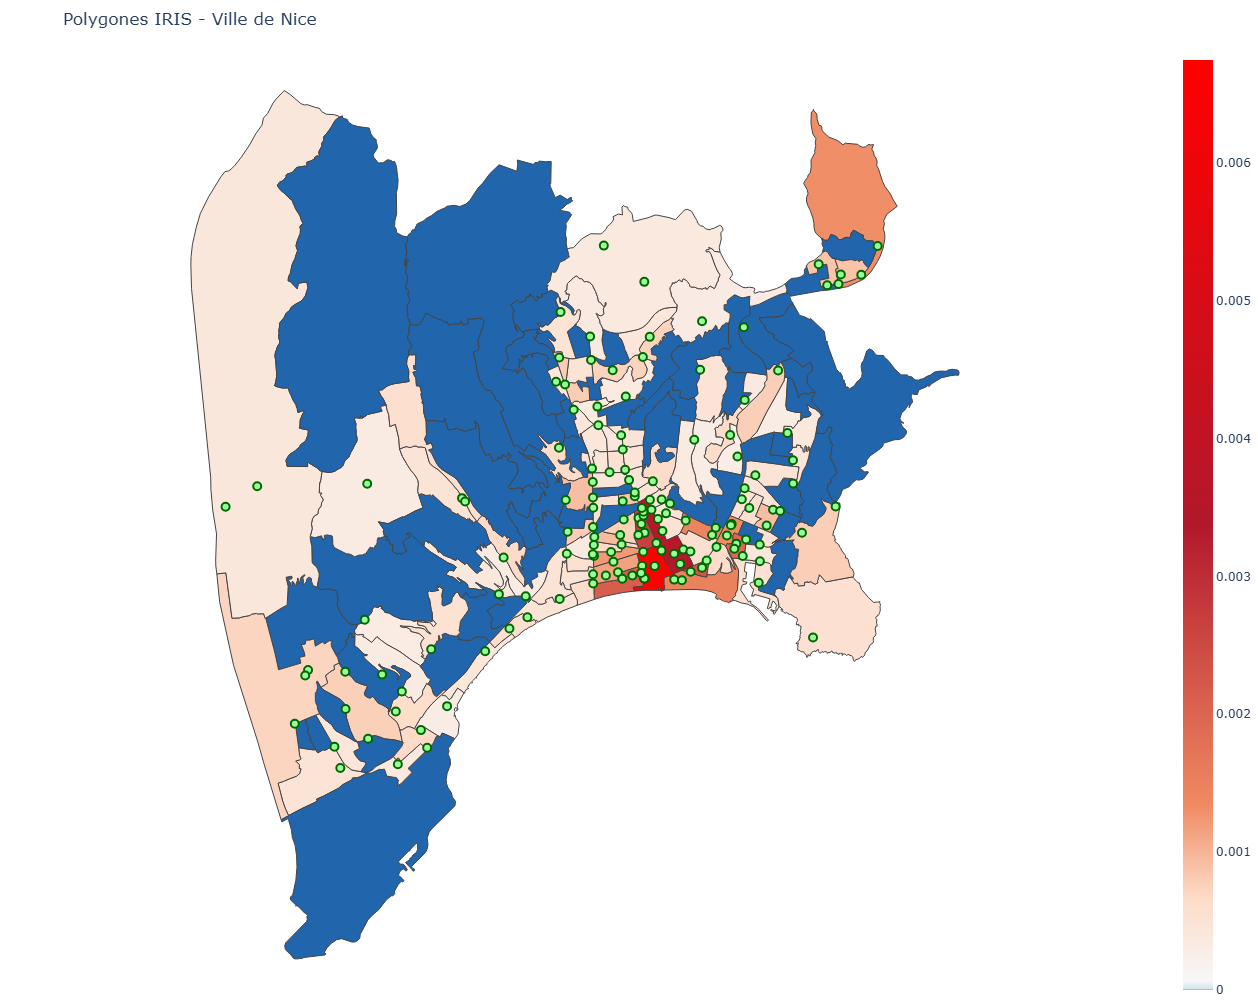

In [6]:
# Créer la figure
fig = go.Figure()

z_values=gdf["ratio"]

fig.add_trace(go.Choropleth(
    geojson=geojson,
    locations=gdf["fid"],
    z=z_values,
    zmin=z_values.min(),
    zmax=z_values.max(),
    text=gdf.apply(
        lambda row: f"Nom: {row['nom_iris']}<br>Nb: {row['nb']}<br>Population: {np.round(row['pop'],0):.0f}<br>Ratio: {np.round(row['ratio']*100000,0):.0f}/100k",
        axis=1
    ),
    hoverinfo="text",
    showscale=True,
    colorscale = [
        [0.0, "#2166ac"],   # bleu foncé
        [0.0001, "#67a9cf"],   # bleu moyen
        [0.001, "#d1e5f0"],   # bleu très clair
        [0.01, "#f7f7f7"],   # blanc
        [0.1, "#fddbc7"],   # rose très clair
        [0.2, "#ef8a62"],   # rouge moyen
        [0.5, "#b2182b"],   # rouge foncé
        [1.0, "#ff0000"]    # rouge foncé
    ],
))

center_lat = gdf.geometry.centroid.y.mean()
center_lon = gdf.geometry.centroid.x.mean()

# Ajouter les étiquettes
gdf_l93 = gdf.to_crs(2154)
pts_l93 = gdf_l93.geometry.representative_point()
pts = pts_l93.to_crs(4326)

fig.add_trace(go.Scattergeo(
    lon=etab["lon"],
    lat=etab["lat"],
    text=etab["rs"],
    hoverinfo="skip",
    showlegend=False,
    marker=dict(
            color='#99ff99',
            size=8,
            line=dict(
                color='#006600',
                width=2
            )
        ),
))

# Mise en page
fig.update_layout(
    geo=dict(
        projection_type="mercator",
        center={"lat": center_lat, "lon": center_lon},
        fitbounds="locations",
        showland=False,
        showcountries=False,
        showocean=False,
        showlakes=False,
        showrivers=False,
        visible=False
    ),
    title="Polygones IRIS - Ville de Nice",
    height=1000,
    width=1200,
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()

In [7]:
# pio.write_html(fig, file="ma_carte.html", auto_open=True, include_plotlyjs="cdn", full_html=True, config={"responsive": True})